In [171]:
import os
from utils import *
import optuna
from Data_manager.Dataset import *

In [172]:
data, usermap, itemmap, users = load_data2()
data_train, data_val = split_data2(data, 0.2)

In [173]:
from Recommenders.Recommender_import_list import *

candidate_generator_recommender = ItemKNNCFRecommender(data_train)
candidate_generator_recommender.fit()

ItemKNNCFRecommender: URM Detected 225 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 129 ( 0.6%) items with no interactions.
Similarity column 22222 (100.0%), 8730.45 column/sec. Elapsed time 2.55 sec


In [174]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = data_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [175]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
12633,NaN
12634,NaN
12635,NaN


In [176]:
cutoff = 30

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 12638/12638 [00:09<00:00, 1334.21it/s]


In [177]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,674
0,587
0,4
0,1118
0,1478
...,...
12637,696
12637,689
12637,811


In [178]:
URM_validation_coo = sps.coo_matrix(data_val)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,0
1,0,2
2,0,4
3,0,5
4,0,8
...,...,...
95741,12637,13248
95742,12637,16341
95743,12637,16594
95744,12637,17581


In [179]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,674,left_only
1,0,587,left_only
2,0,4,both
3,0,1118,left_only
4,0,1478,left_only
...,...,...,...
379135,12637,696,left_only
379136,12637,689,left_only
379137,12637,811,left_only
379138,12637,3024,left_only


In [180]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,674,False
1,0,587,False
2,0,4,True
3,0,1118,False
4,0,1478,False
...,...,...,...
379135,12637,696,False
379136,12637,689,False
379137,12637,811,False
379138,12637,3024,False


In [181]:
topPop = TopPop(data_train)
topPop.fit()

p3alpha = P3alphaRecommender(data_train)
p3alpha.fit()

slimbpr = SLIM_BPR_Cython(data_train)
slimbpr.fit()


other_algorithms = {
    "TopPop": topPop,
    "P3alpha": p3alpha,
    "SLIM_BPR": slimbpr,
}

TopPopRecommender: URM Detected 225 ( 1.8%) users with no interactions.
TopPopRecommender: URM Detected 129 ( 0.6%) items with no interactions.
P3alphaRecommender: URM Detected 225 ( 1.8%) users with no interactions.
P3alphaRecommender: URM Detected 129 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 3153.27 column/sec. Elapsed time 7.05 sec
SLIM_BPR_Recommender: URM Detected 225 ( 1.8%) users with no interactions.
SLIM_BPR_Recommender: URM Detected 129 ( 0.6%) items with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 12638 (100.0%) in 0.97 sec. BPR loss is 2.54E-07. Sample per second: 13051
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.05 sec
Processed 12638 (100.0%) in 1.02 sec. BPR loss is 8.49E-07. Sample per second: 12424
SLIM_BPR_Recom

In [182]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/12638 [00:00<?, ?it/s]

Deallocating Cython objects


100%|██████████| 12638/12638 [00:18<00:00, 676.54it/s]


,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR
0,0,674,False,334.0,0.000000,0.013484
1,0,587,False,566.0,0.000000,0.016286
2,0,4,True,204.0,0.000000,0.009671
3,0,1118,False,103.0,0.014066,0.006305
4,0,1478,False,299.0,0.000000,0.007097
...,...,...,...,...,...,...
379135,12637,696,False,85.0,0.004646,0.006998
379136,12637,689,False,144.0,0.000000,0.008651
379137,12637,811,False,540.0,0.000000,0.016713
379138,12637,3024,False,60.0,0.000000,0.005410


In [183]:
item_popularity = np.ediff1d(sps.csc_matrix(data_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity
0,0,674,False,334.0,0.000000,0.013484,334
1,0,587,False,566.0,0.000000,0.016286,566
2,0,4,True,204.0,0.000000,0.009671,204
3,0,1118,False,103.0,0.014066,0.006305,103
4,0,1478,False,299.0,0.000000,0.007097,299
...,...,...,...,...,...,...,...
379135,12637,696,False,85.0,0.004646,0.006998,85
379136,12637,689,False,144.0,0.000000,0.008651,144
379137,12637,811,False,540.0,0.000000,0.016713,540
379138,12637,3024,False,60.0,0.000000,0.005410,60


In [184]:
user_popularity = np.ediff1d(sps.csr_matrix(data_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,674,False,334.0,0.000000,0.013484,334,31
1,0,587,False,566.0,0.000000,0.016286,566,31
2,0,4,True,204.0,0.000000,0.009671,204,31
3,0,1118,False,103.0,0.014066,0.006305,103,31
4,0,1478,False,299.0,0.000000,0.007097,299,31
...,...,...,...,...,...,...,...,...
379135,12637,696,False,85.0,0.004646,0.006998,85,53
379136,12637,689,False,144.0,0.000000,0.008651,144,53
379137,12637,811,False,540.0,0.000000,0.016713,540,53
379138,12637,3024,False,60.0,0.000000,0.005410,60,53


In [185]:
training_dataframe = training_dataframe.drop("ItemID", axis=1)
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

,ItemID,UserID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,0,False,334.0,0.000000,0.013484,334,31
1,1,0,False,566.0,0.000000,0.016286,566,31
2,2,0,True,204.0,0.000000,0.009671,204,31
3,3,0,False,103.0,0.014066,0.006305,103,31
4,4,0,False,299.0,0.000000,0.007097,299,31
...,...,...,...,...,...,...,...,...
379135,379135,12637,False,85.0,0.004646,0.006998,85,53
379136,379136,12637,False,144.0,0.000000,0.008651,144,53
379137,379137,12637,False,540.0,0.000000,0.016713,540,53
379138,379138,12637,False,60.0,0.000000,0.005410,60,53


In [186]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [187]:
from xgboost import XGBRanker

In [188]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [189]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [190]:

# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.9553342 ,  1.3474076 ,  1.4228861 ,  0.3225758 ,  0.41694242,
        0.8524455 ,  0.9024827 ,  0.29372162,  0.82888883,  0.0554901 ,
        0.3405262 ,  0.26801756,  0.06199389,  0.20059972,  0.09611206,
        0.06416471, -0.25387874,  0.04886214,  0.6993372 , -0.15689582,
       -0.30922672,  0.58604145,  0.0375358 , -0.22828953, -0.25387874,
       -0.14538127, -0.30922672,  0.5343665 ,  0.09611206, -0.1143665 ],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

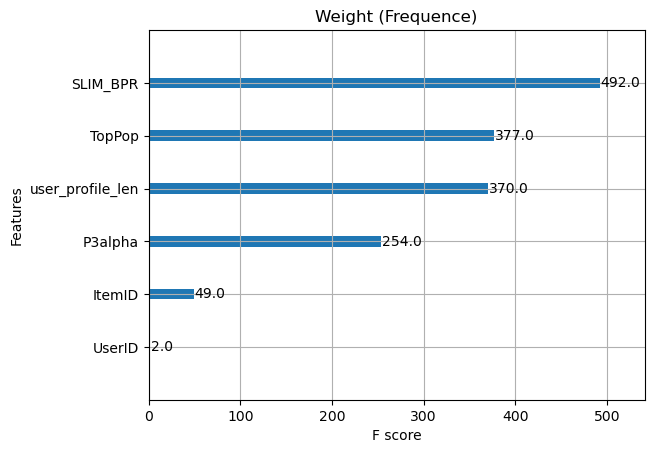

In [191]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [192]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [193]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [194]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.00679333,  0.055412  ,  0.055412  , -0.0055108 , -0.0055108 ,
        0.2093586 ,  0.03553754, -0.0055108 , -0.01556319, -0.02538525,
       -0.0055108 , -0.0055108 , -0.02538525, -0.02538525, -0.02538525,
       -0.02538525, -0.08708609, -0.02538525, -0.09757549, -0.04550062,
       -0.08708609, -0.03821472, -0.02538525, -0.06815215, -0.08708609,
       -0.05622268, -0.08708609, -0.03821472, -0.02538525, -0.02538525],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

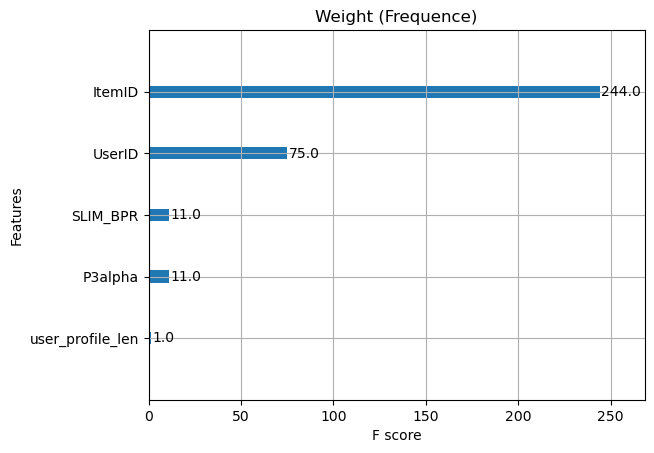

In [195]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [201]:
submission2(slimbpr, users, usermap, itemmap, data_train)

TopPopRecommender: URM Detected 225 ( 1.8%) users with no interactions.
TopPopRecommender: URM Detected 129 ( 0.6%) items with no interactions.
